In [11]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
andrewmvd_lung_and_colon_cancer_histopathological_images_path = kagglehub.dataset_download('andrewmvd/lung-and-colon-cancer-histopathological-images')

print('Data source import complete.')


Data source import complete.


### Import needed modules

In [60]:
#import system libs
import os
import time
import shutil
import pathlib
import itertools
from PIL import Image

# import data handling tools
import cv2
import random
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

#import Deep learing Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam , Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Flatten,Dense,Activation,Dropout,BatchNormalization
from tensorflow.keras import regularizers

#Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print('modules loaded')

modules loaded


## Data Preprocessing

### Read data and store it in dataframe

In [13]:
data_dir = '/kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set'
filepaths = []
labels = []

folds = os.listdir(data_dir) # ['colon_image_sets','lung_image_sets']
for fold in folds:
    foldpath = os.path.join(data_dir, fold) #data_dir + colon_image_sets , data_dir + lung_image_sets
    flist = os.listdir(foldpath) #['colon_aca', 'colon_n'], ['lung_aca', 'lung_scc', 'lung_n']
    #print(foldpath)
    #print(flist)

    for f in flist:
        f_path = os.path.join(foldpath, f) # foldpath/colon_aca,foldpath/colon_n,foldpath/lung_aca,foldpath/lung_scc,foldpath/lung_n
        filelist = os.listdir(f_path) # the images
        #print(f_path)
        #print(filelist)

        for file in filelist:
            fpath = os.path.join(f_path, file) # the complete path to images
            filepaths.append(fpath)
            #print(fpath)
            #print(filepaths)

            if f == 'colon_aca':
                labels.append('Colon Adenocarcinoma')

            elif f == 'colon_n':
                labels.append('Colon Benign Tissue')

            elif f == 'lung_aca':
                labels.append('Lung Adenocarcinoma')

            elif f == 'lung_n':
                labels.append('Lung Benign Tissue')

            elif f == 'lung_scc':
                labels.append('Lung Squamous Cells Carcinoma')

# Concatenate data paths with labels into one dataframe

Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name = 'labels')
df = pd.concat([Fseries, Lseries], axis = 1)

In [14]:
df

filepaths                labels
0      /kaggle/input/lung-and-colon-cancer-histopatho...  Colon Adenocarcinoma
1      /kaggle/input/lung-and-colon-cancer-histopatho...  Colon Adenocarcinoma
2      /kaggle/input/lung-and-colon-cancer-histopatho...  Colon Adenocarcinoma
3      /kaggle/input/lung-and-colon-cancer-histopatho...  Colon Adenocarcinoma
4      /kaggle/input/lung-and-colon-cancer-histopatho...  Colon Adenocarcinoma
...                                                  ...                   ...
24995  /kaggle/input/lung-and-colon-cancer-histopatho...    Lung Benign Tissue
24996  /kaggle/input/lung-and-colon-cancer-histopatho...    Lung Benign Tissue
24997  /kaggle/input/lung-and-colon-cancer-histopatho...    Lung Benign Tissue
24998  /kaggle/input/lung-and-colon-cancer-histopatho...    Lung Benign Tissue
24999  /kaggle/input/lung-and-colon-cancer-histopatho...    Lung Benign Tissue

[25000 rows x 2 columns]

In [15]:
strat = df['labels']
train_df, dummy_df = train_test_split(df, train_size=0.8, shuffle=True, random_state= 123, stratify =strat)

# valid and test dataframe
strat = dummy_df['labels']
valid_df , test_df = train_test_split(dummy_df, train_size= 0.5,shuffle=True, random_state= 123 ,stratify=strat)

## Create image data generator

In [48]:
batch_size = 64
img_size = (224,224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels', target_size= img_size, class_mode= 'categorical',
                                       color_mode='rgb', shuffle=False, batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe(valid_df, x_col='filepaths', y_col='labels', target_size= img_size, class_mode= 'categorical',
                                       color_mode='rgb', shuffle=False, batch_size= batch_size)

test_gen = ts_gen.flow_from_dataframe(test_df,
                                    x_col='filepaths',
                                    y_col='labels',
                                    target_size=img_size,
                                    class_mode='categorical',
                                    color_mode='rgb',  # Fixed typo
                                    shuffle=False,     # Fixed typo
                                    batch_size=batch_size)

Found 20000 validated image filenames belonging to 5 classes.
Found 2500 validated image filenames belonging to 5 classes.
Found 2500 validated image filenames belonging to 5 classes.


## Show sample from train data

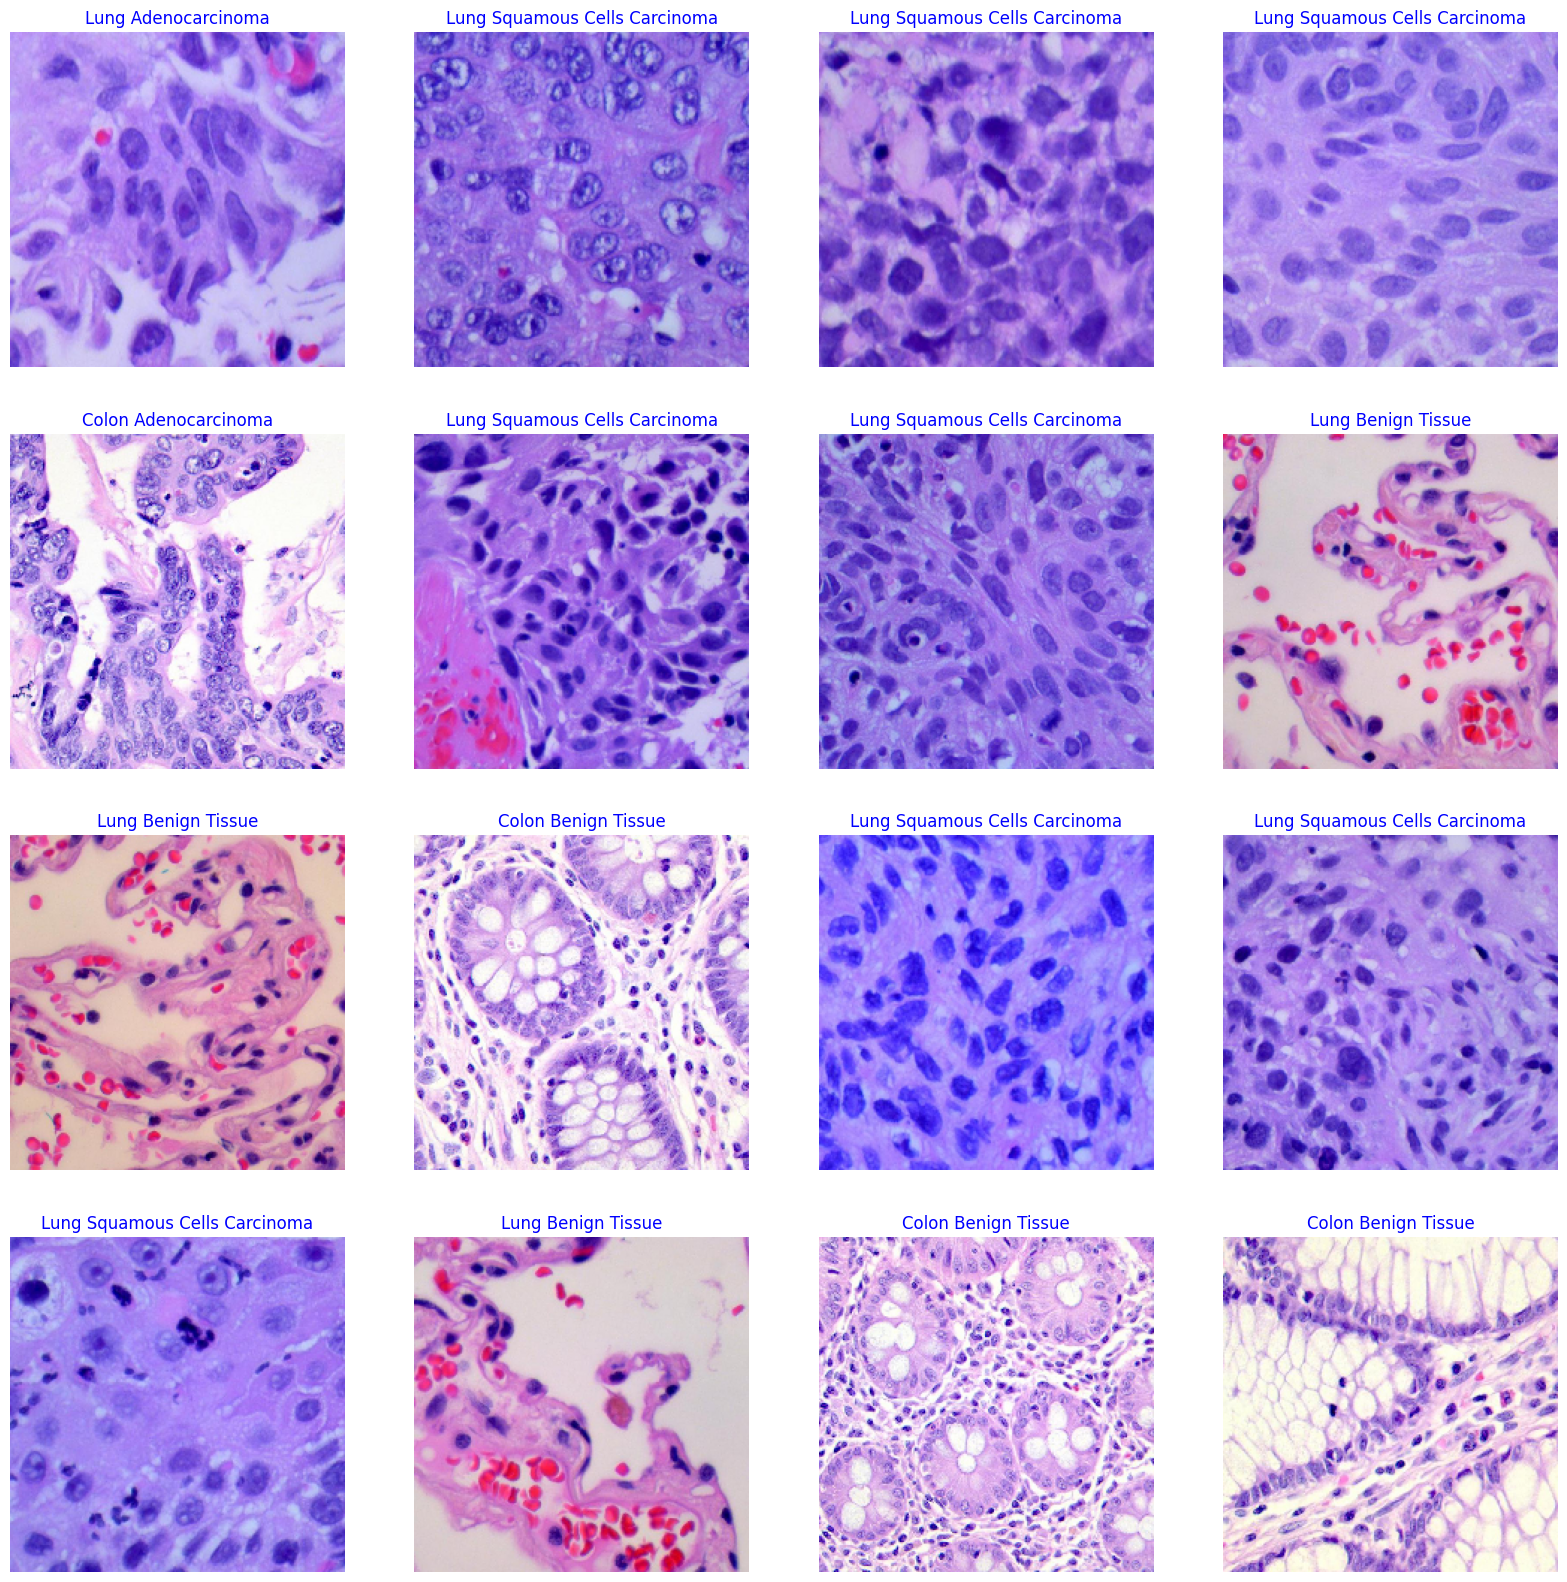

In [17]:
g_dict = train_gen.class_indices # defines dictionary {'class':'index'}

classes = list(g_dict.keys()) # defines list of dictionary's kays (classes), classes names : string

images, labels = next(train_gen) # get a batch size samples from the generator

plt.figure(figsize=(20,20))

for i in range(16):
    plt.subplot(4,4,i+1)
    image = images[i] / 255 # scales data to range (0-255)
    plt.imshow(image)
    index = np.argmax(labels[i]) # get image index
    class_name = classes[index]
    plt.title(class_name, color='blue',fontsize=12)
    plt.axis('off')

plt.show()

In [18]:
# Create Model Structure
img_size = (224,224)
channels = 3
img_shape = (img_size[0],img_size[1],channels)
class_count = len(list(train_gen.class_indices.keys()))

model = Sequential([

    Conv2D(filters=64, kernel_size=(3,3),padding="same",
          activation='relu', input_shape= img_shape),
    Conv2D(filters=64, kernel_size=(3,3), padding="same",
          activation='relu'),
    MaxPooling2D((2,2)),

    Conv2D(filters=128, kernel_size=(3,3), padding="same"
          ,activation ='relu'),
    Conv2D(filters=128, kernel_size=(3,3), padding="same"
          ,activation ='relu'),
    MaxPooling2D((2,2)),

    Conv2D(filters=256, kernel_size=(3,3), padding="same"
          ,activation='relu'),
    Conv2D(filters=256, kernel_size=(3,3), padding="same"
          ,activation='relu'),
    Conv2D(filters=256, kernel_size=(3,3), padding="same"
          ,activation='relu'),
    MaxPooling2D((2,2)),

    Conv2D(filters=512, kernel_size=(3,3), padding="same"
          ,activation='relu'),
    Conv2D(filters=512, kernel_size=(3,3), padding="same"
          ,activation='relu'),
    Conv2D(filters=512, kernel_size=(3,3), padding="same"
          ,activation='relu'),
    MaxPooling2D((2,2)),

    Conv2D(filters=512, kernel_size=(3,3), padding="same"
          ,activation='relu'),
    Conv2D(filters=512, kernel_size=(3,3), padding="same"
          ,activation='relu'),
    Conv2D(filters=512, kernel_size=(3,3), padding="same"
          ,activation='relu'),
    MaxPooling2D((2,2)),


    Flatten(),
    Dense(256,activation = 'relu'),
    Dense(64,activation='relu'),
    Dense(class_count,activation='softmax')
    ])

In [19]:
model.compile(Adamax(learning_rate=0.001),loss='categorical_crossentropy',metrics=['accuracy'])

In [20]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,154,245 (80.70 MB)

 Trainable params: 21,154,245 (80.70 MB)

 Non-trainable params: 0 (0.00 B)

In [21]:
epochs = 20

history = model.fit(x=train_gen, epochs=epochs , verbose= 1, validation_data= test_gen,
                   validation_steps=None , shuffle= False)

Epoch 1/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 406s 1s/step - accuracy: 0.4819 - loss: 19.3413 - val_accuracy: 0.8836 - val_loss: 0.3136
Epoch 2/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 281s 898ms/step - accuracy: 0.8900 - loss: 0.2923 - val_accuracy: 0.9304 - val_loss: 0.1861
Epoch 3/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 282s 902ms/step - accuracy: 0.9197 - loss: 0.2166 - val_accuracy: 0.9248 - val_loss: 0.1988
Epoch 4/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 283s 902ms/step - accuracy: 0.9400 - loss: 0.1581 - val_accuracy: 0.9264 - val_loss: 0.2040
Epoch 5/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 289s 923ms/step - accuracy: 0.9564 - loss: 0.1178 - val_accuracy: 0.9484 - val_loss: 0.1475
Epoch 6/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 283s 904ms/step - accuracy: 0.9656 - loss: 0.0927 - val_accuracy: 0.9708 - val_loss: 0.0856
Epoch 7/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 284s 905ms/step - accuracy: 0.9671 - loss: 0.0857 - val_accuracy: 0.9584 - val_loss: 0.1100
Epoch 8/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 323s 908ms/step - accuracy: 0.9750 - l

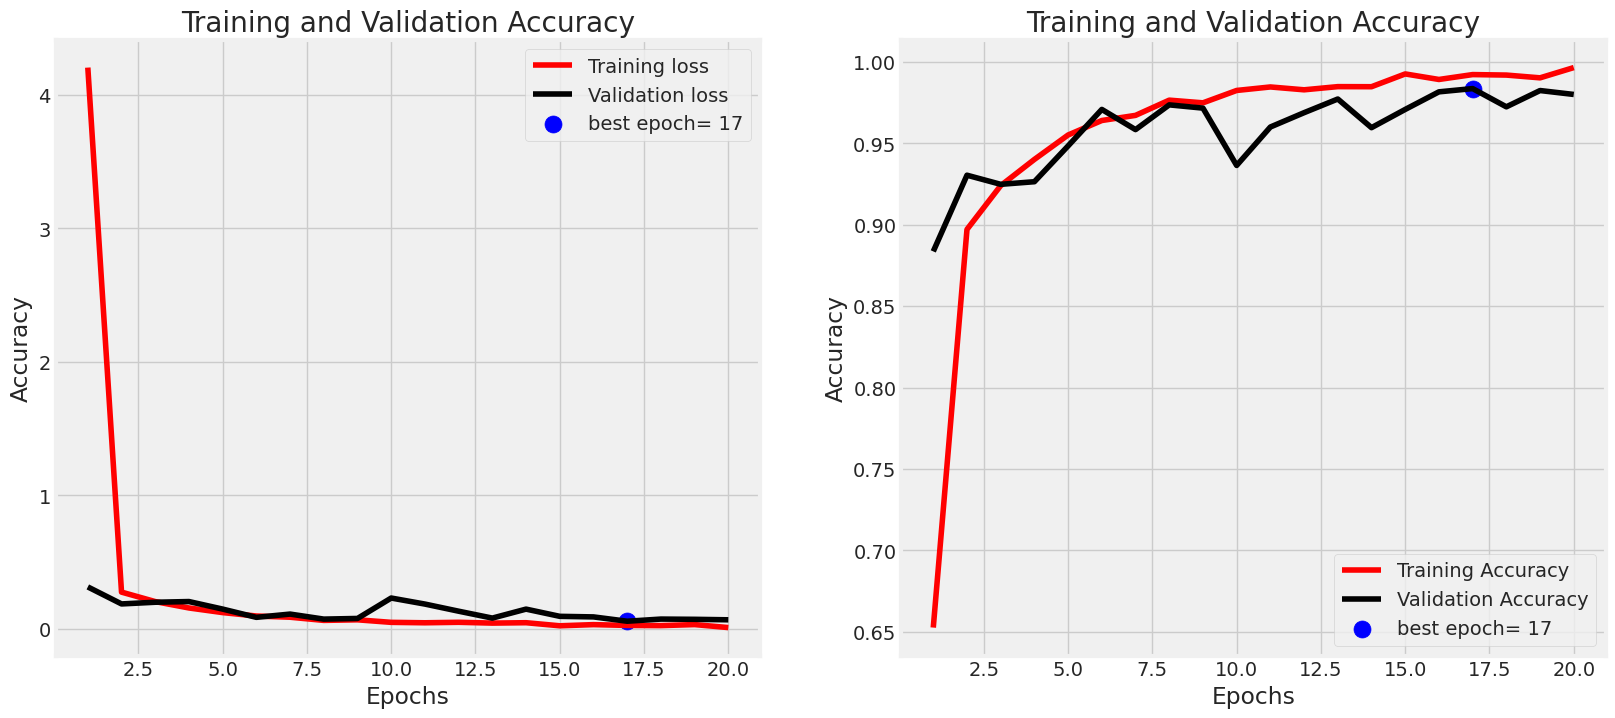

In [22]:
# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize=(20,8))
plt.style.use('fivethirtyeight')

plt.subplot(1,2,1)
plt.plot(Epochs, tr_loss, 'r', label='Training loss')
plt.plot(Epochs, val_loss, 'k', label='Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150 , c='blue', label =acc_label )
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'k', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()


plt.tight_layout
plt.show()

## Evaluate model

In [23]:
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length +1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen , steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen , steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print('Train Loss: ',train_score[0])
print('Train Accuracy: ',train_score[1])
print('-' * 20)
print("Valid Loss: ", valid_score[0])
print("Valid Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

50/50 ━━━━━━━━━━━━━━━━━━━━ 18s 361ms/step - accuracy: 0.9939 - loss: 0.0135
50/50 ━━━━━━━━━━━━━━━━━━━━ 22s 426ms/step - accuracy: 0.9836 - loss: 0.0623
50/50 ━━━━━━━━━━━━━━━━━━━━ 15s 285ms/step - accuracy: 0.9780 - loss: 0.0782
Train Loss:  0.014873743057250977
Train Accuracy:  0.9937499761581421
--------------------
Valid Loss:  0.07029500603675842
Valid Accuracy:  0.9815999865531921
--------------------
Test Loss:  0.06716568022966385
Test Accuracy:  0.9800000190734863


## Get Predictions

In [49]:
# Reset generator and get predictions
test_gen.reset()
preds = model.predict(test_gen, steps=len(test_gen), verbose=1)
y_pred = np.argmax(preds, axis=1)
y_true = test_gen.classes  # Or use manual extraction (Fix 2)

# Debug: Check alignment
print("Class indices:", test_gen.class_indices)
print("First 5 true vs pred:", y_true[:5], y_pred[:5])



40/40 ━━━━━━━━━━━━━━━━━━━━ 15s 376ms/step
Class indices: {'Colon Adenocarcinoma': 0, 'Colon Benign Tissue': 1, 'Lung Adenocarcinoma': 2, 'Lung Benign Tissue': 3, 'Lung Squamous Cells Carcinoma': 4}
First 5 true vs pred: [4, 0, 3, 4, 0] [4 0 3 4 0]


#### Confusion Matrics and Classification Report

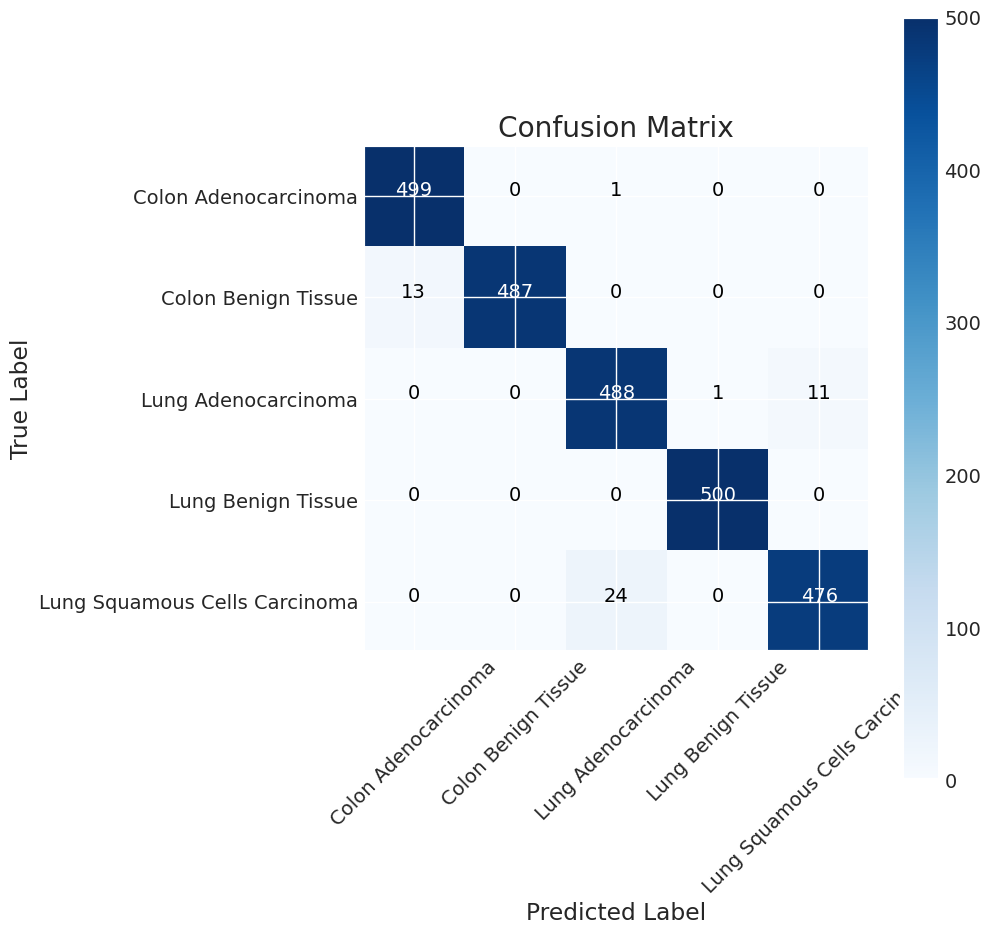

In [51]:

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

classes = list(test_gen.class_indices.keys())

plt.figure(figsize=(10, 10))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


In [52]:
# Classification report
print(classification_report(test_gen.classes, y_pred, target_names = classes))

                               precision    recall  f1-score   support

         Colon Adenocarcinoma       0.97      1.00      0.99       500
          Colon Benign Tissue       1.00      0.97      0.99       500
          Lung Adenocarcinoma       0.95      0.98      0.96       500
           Lung Benign Tissue       1.00      1.00      1.00       500
Lung Squamous Cells Carcinoma       0.98      0.95      0.96       500

                     accuracy                           0.98      2500
                    macro avg       0.98      0.98      0.98      2500
                 weighted avg       0.98      0.98      0.98      2500



#### save model

In [53]:
model.save('Model.h5')

Prediction using loaded_model

In [68]:
test_gen.reset()
images, true_labels = next(test_gen)  # Get one batch (batch_size=64)

# Predict
preds = model.predict(images)
y_pred = np.argmax(preds, axis=1)
y_true = np.argmax(true_labels, axis=1)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


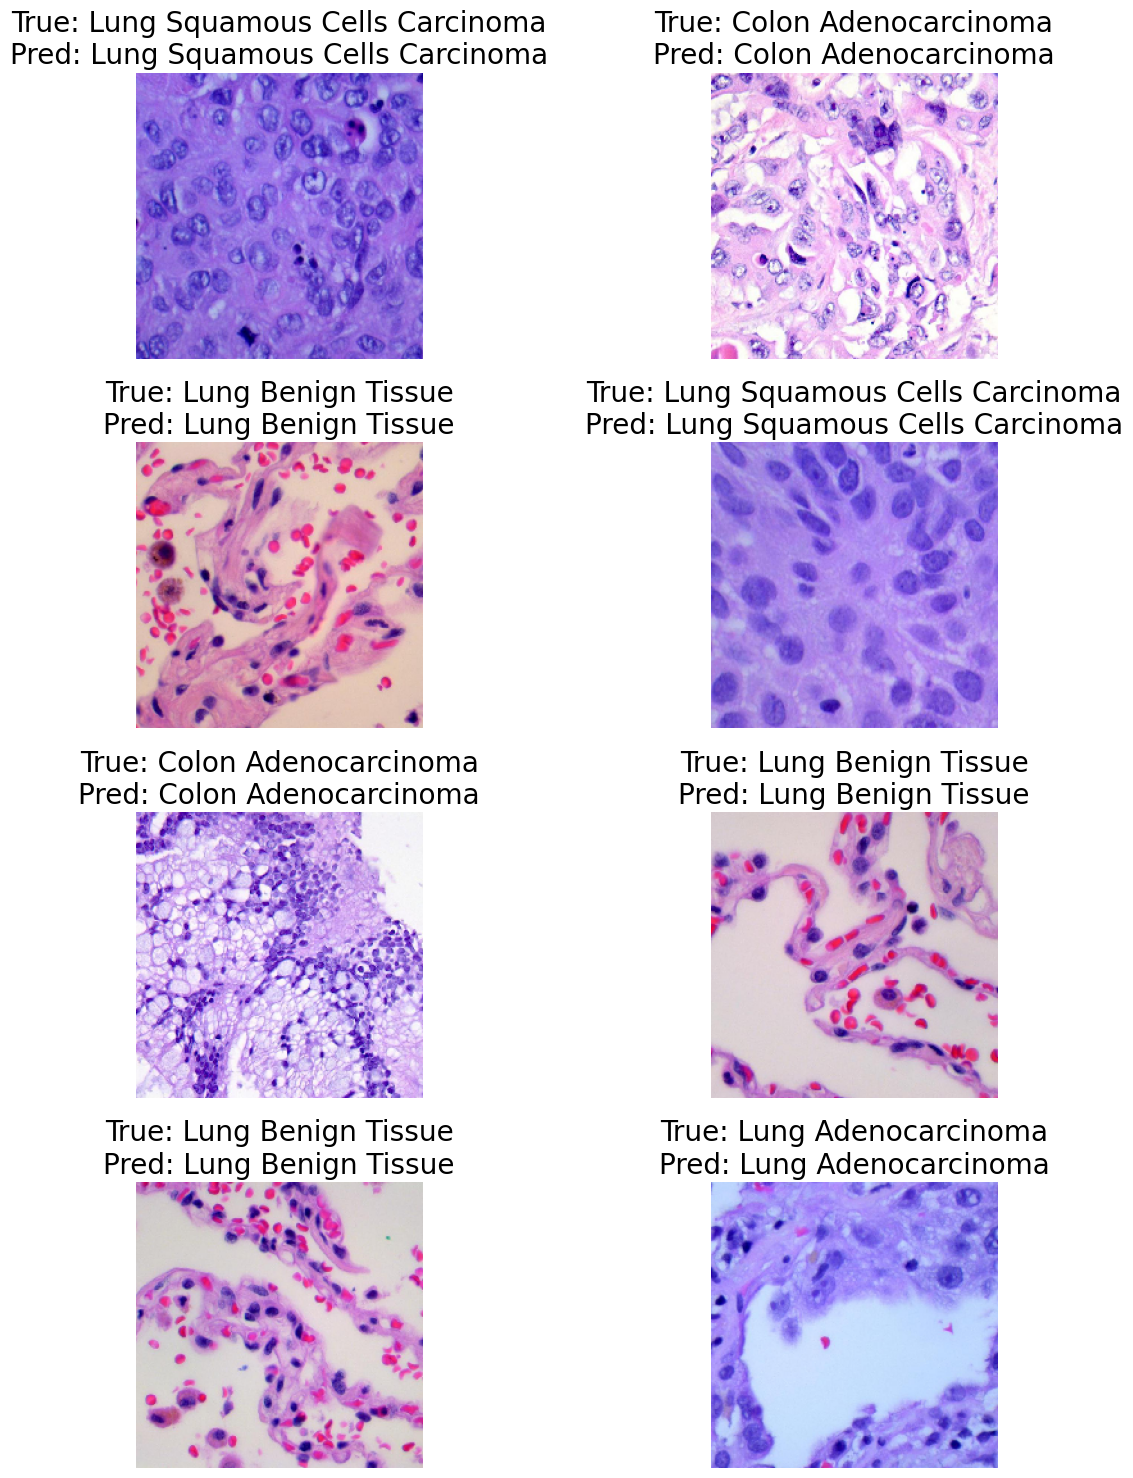

In [69]:
# Predict
preds = model.predict(images)
y_pred = np.argmax(preds, axis=1)
y_true = np.argmax(true_labels, axis=1)

# Plot
plt.figure(figsize=(15, 15))
for i in range(8):
    plt.subplot(4, 2, i+1)
    img = array_to_img(images[i])
    plt.imshow(img)

    true_class = classes[y_true[i]]
    pred_class = classes[y_pred[i]]

    color = 'black' if y_true[i] == y_pred[i] else 'red'
    plt.title(f"True: {true_class}\nPred: {pred_class}", color=color)
    plt.axis('off')

plt.tight_layout()
plt.show()